# Forecasting with linear regression

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [3]:
df = pd.read_csv("frequent.csv", index_col=0)

In [4]:
frequent_products = ((df != 0).sum() / df.shape[0]).sort_values(ascending = False)[:50]

frequent_products

ENTREGA                                          0.883903
GE2 CELULAR                                      0.847578
GE1 ELETROPORTATEIS                              0.846154
GE1 CELULAR                                      0.787749
CHIP VIVO 4G 128K P19 HRS PRE                    0.776353
GE1 TV LCD LED                                   0.768519
CHIP CLARO ODA 128KB TRIPE                       0.752849
GE1 MOVEIS 1                                     0.747863
GE2 REFRIGERADOR                                 0.730769
CHIP TIM INFINITY PRE HRD TRIPLO 4G              0.683048
FERRO SECO METALICO VFA 1110X BLACK E DECKER     0.667379
GRILL E SAND S-11 220V                           0.641026
LIQUID.L-28 POWER BLACK 2V                       0.625356
SANDUICHEIRA S-12 FAST 220V                      0.618946
GE2 TV LCD LED                                   0.612536
VENTILADOR VF40 SILENCE FORCE CD RE              0.596866
DVD D-14 GAME STAR II MONDIAL                    0.591880
CORTADOR DE CA

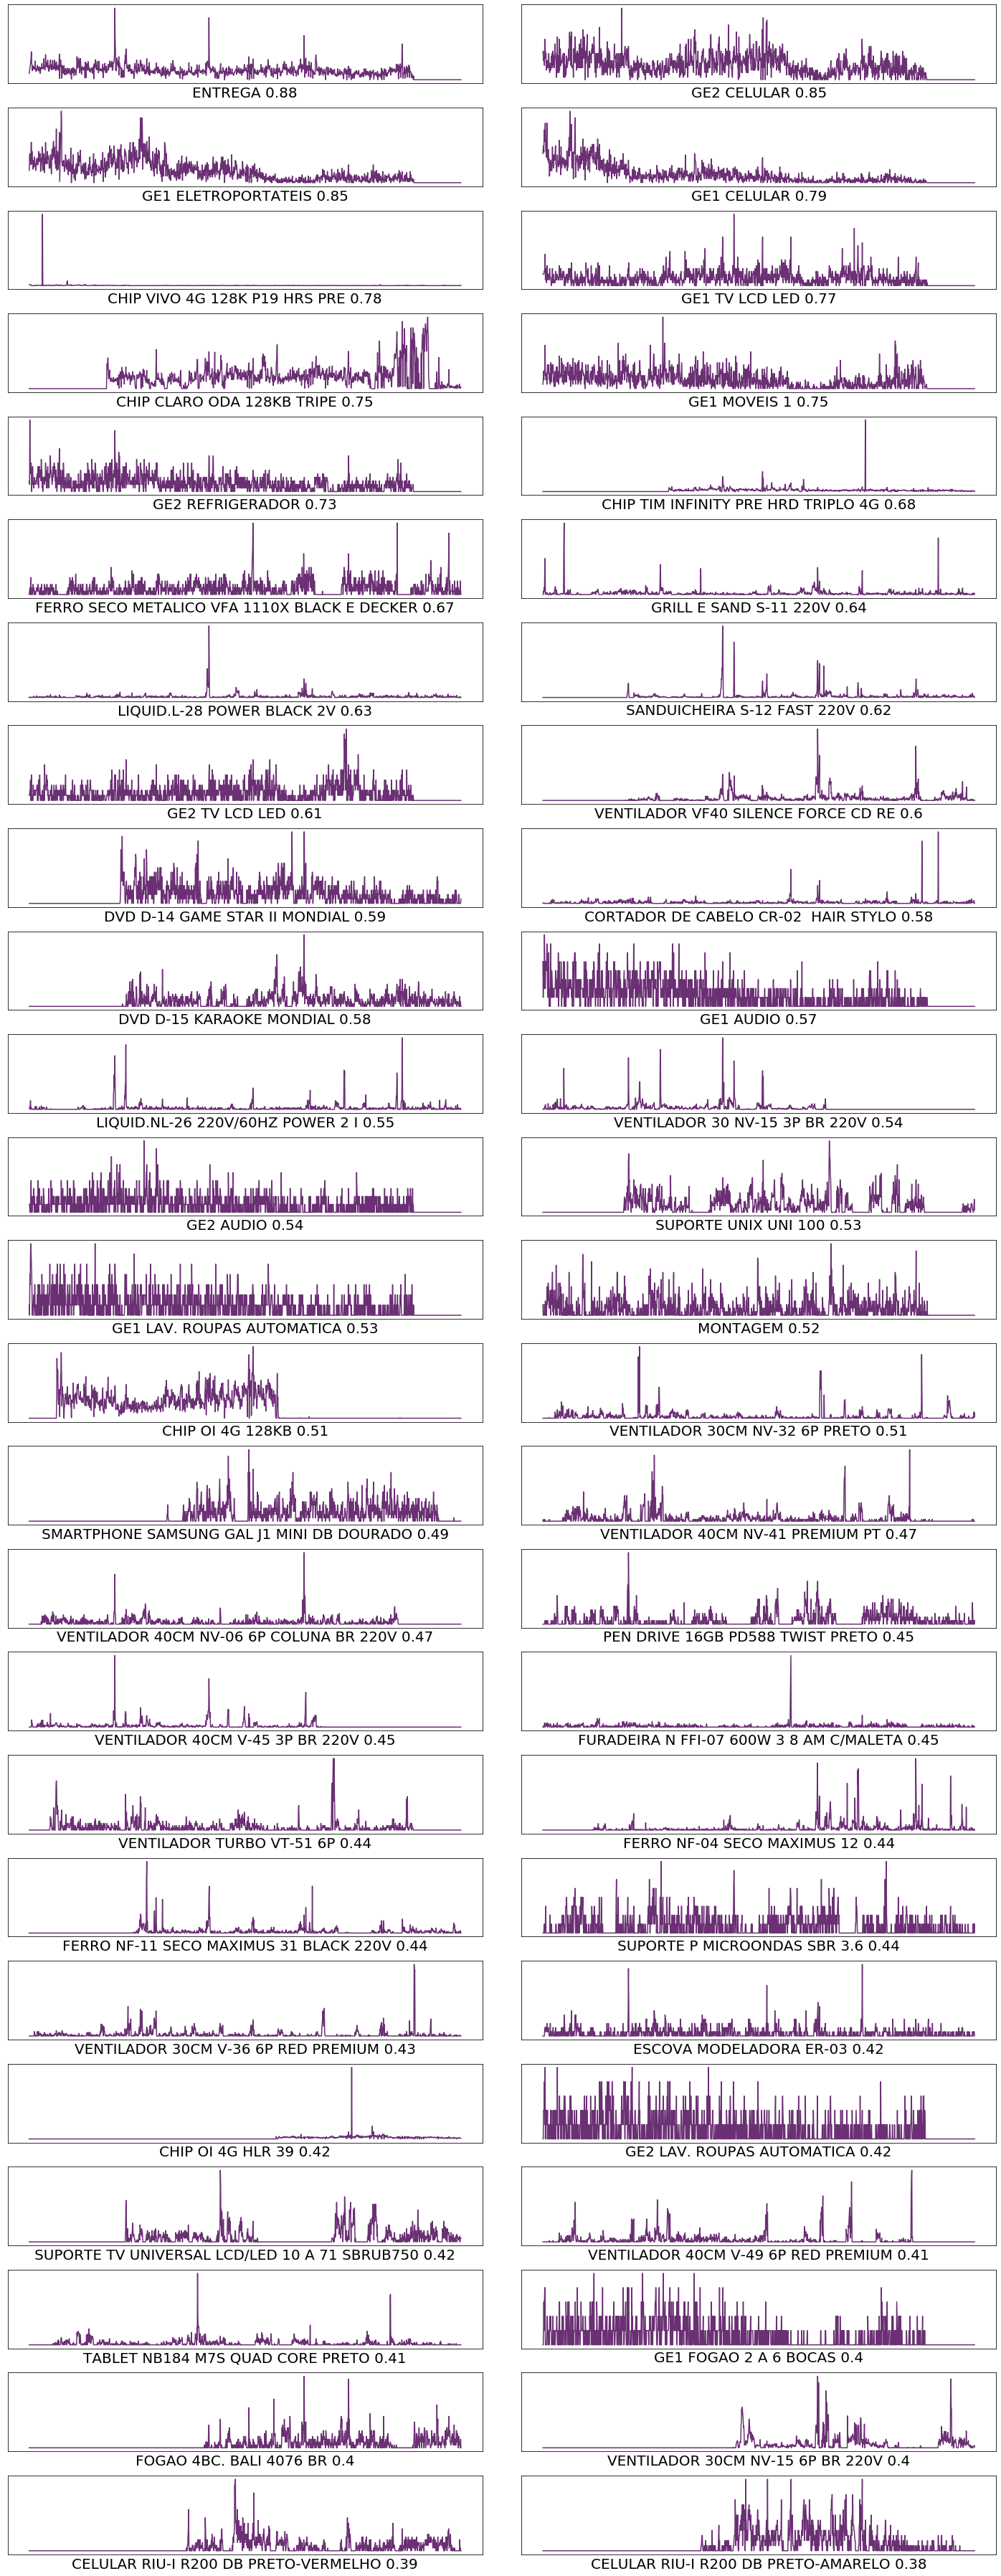

In [5]:
plt.figure(figsize=(20,50))
for i in range(len(df.columns)):
    plt.subplot(25, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.plot(df[df.columns[i]], color="#6b3074")
    plt.xlabel(df.columns[i] + " " + str(np.round(frequent_products[df.columns[i]],2)), fontsize=20)
plt.tight_layout()
plt.show()

## Decomposing the data

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
ferro = df["FERRO SECO METALICO VFA 1110X BLACK E DECKER"]

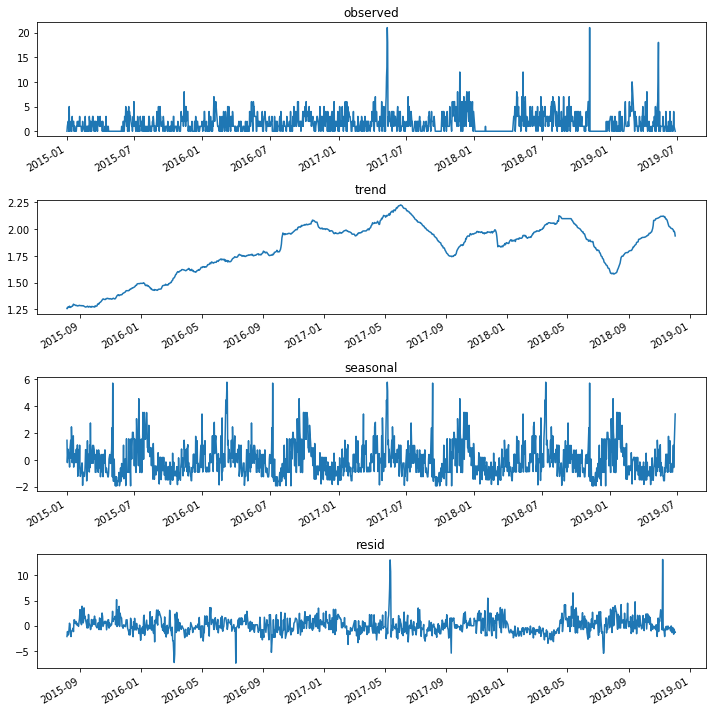

In [8]:
%matplotlib inline
result = seasonal_decompose(ferro, model = 'additive', period=365)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(10,10))
result.observed.plot(ax = ax1, title = "observed")
result.trend.plot(ax = ax2, title = "trend")
result.seasonal.plot(ax = ax3, title = "seasonal")
result.resid.plot(ax = ax4, title = "resid")
plt.tight_layout()

In [9]:
ventilador = df["VENTILADOR VF40 SILENCE FORCE CD RE"]

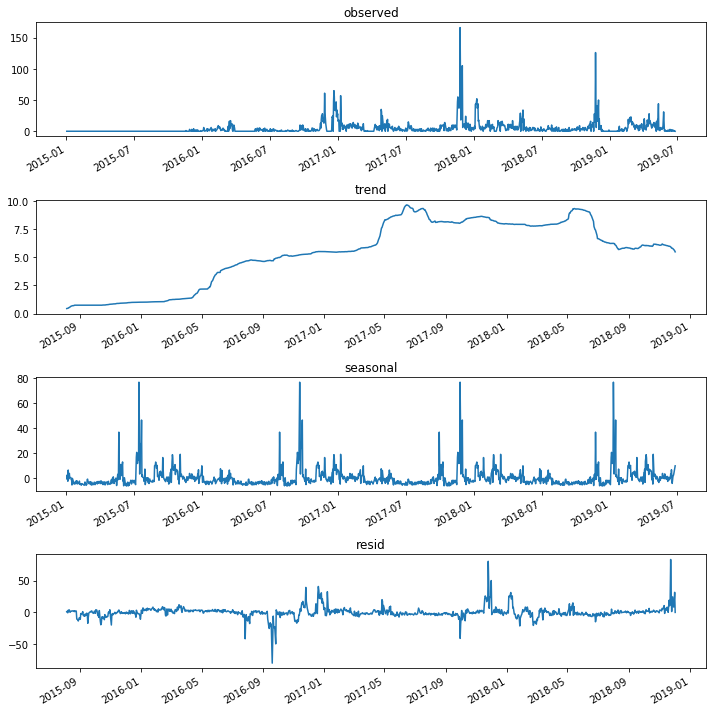

In [10]:
%matplotlib inline
result = seasonal_decompose(ventilador, model = 'additive', period=365)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(10,10))
result.observed.plot(ax = ax1, title = "observed")
result.trend.plot(ax = ax2, title = "trend")
result.seasonal.plot(ax = ax3, title = "seasonal")
result.resid.plot(ax = ax4, title = "resid")
plt.tight_layout()

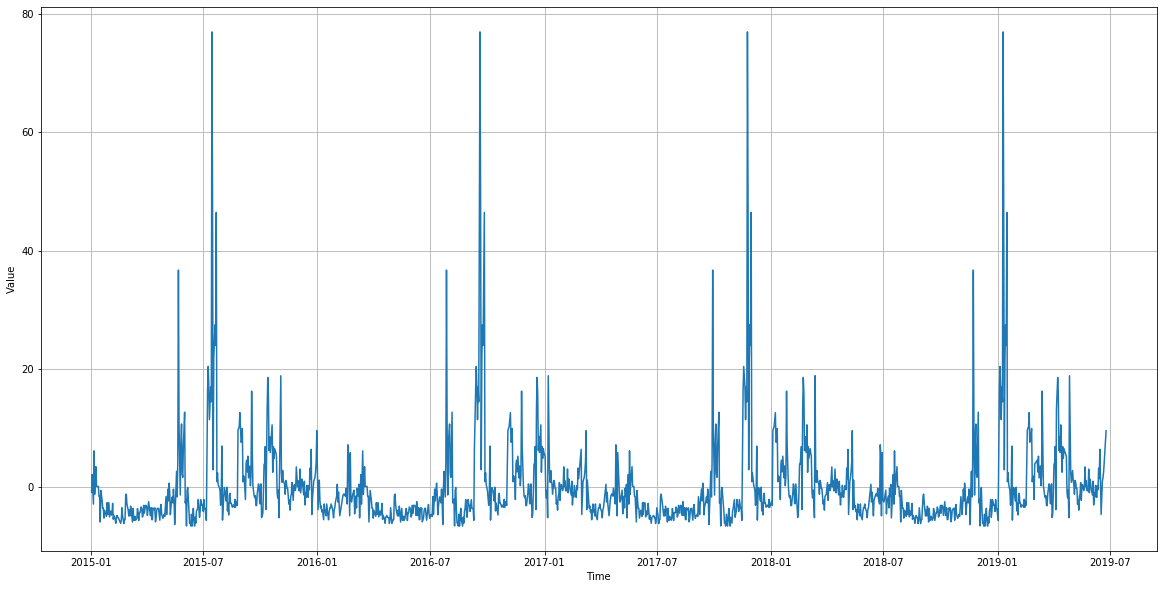

In [11]:
plt.figure(figsize=(20,10))
plot_series(result.seasonal.index, result.seasonal)

* Aqui a gente fez um regressão linear com os dados de 2015 a 2019 e somamos o resultado com a sesonality dos timeframe equivalente de 2019 em 2018.

In [12]:
result.seasonal.index[-1]

Timestamp('2019-06-25 00:00:00')

In [13]:
to_add = result.seasonal.loc[(result.seasonal.index.year == 2018)]
to_add

2018-01-02    -2.342551
2018-01-03    -3.010131
2018-01-04     9.656536
2018-01-05     9.985303
2018-01-06    10.317723
                ...    
2018-12-27    -3.036158
2018-12-28    -4.037528
2018-12-29    -2.044377
2018-12-30    -3.547117
2018-12-31    -3.545747
Name: seasonal, Length: 322, dtype: float64

In [14]:
y_train = ventilador.loc[ventilador.index.year != 2019].fillna(0)

In [15]:
X1 = np.array(ventilador.index.year - 2015).reshape(-1,1) # os anos serão descritos de 0 a 4

X2 = np.array(ventilador.index.month).reshape(-1,1)

X3 = np.array(ventilador.index.day).reshape(-1,1)

X = np.concatenate((X1,X2,X3), axis=1)

In [16]:
X

array([[ 0,  1,  2],
       [ 0,  1,  3],
       [ 0,  1,  5],
       ...,
       [ 4,  6, 21],
       [ 4,  6, 22],
       [ 4,  6, 25]])

In [17]:
class LinearRegressor:
    def execute(self, X, y):
        X = np.array(X)
        y = np.array(y)
        XTX = np.dot(X.transpose(), X)
        inverse = np.linalg.inv(XTX)
        self.W = np.dot(np.dot(inverse, X.transpose()), y)
    
    def predict(self, X):
        return [np.dot(self.W, d) for d in X]

In [18]:
X_train = X[(X[:,0] != 4)] # sem o ano 4 que seria 2019
X_test = X[X[:,0] == 4]

In [19]:
lr = LinearRegressor()

In [20]:
lr.execute(X_train, y_train)

In [21]:
y_pred = lr.predict(X_test)

In [22]:
len(y_pred)

154

In [23]:
X_test.shape

(154, 3)

In [24]:
to_add = to_add.loc[to_add.index.month < 7] # pega só os dados de sazonalidade de 2018, do mesmo período que vamos prever em 2019

In [25]:
to_add = to_add[:-5]

In [26]:
to_add.shape

(150,)

In [27]:
final_result = np.array(to_add) + y_pred[:-4]

In [28]:
data_2019 = ventilador.loc[ventilador.index.year == 2019]
data_2019 = data_2019.loc[data_2019.index.month < 7]
data_2019 = data_2019[4:]

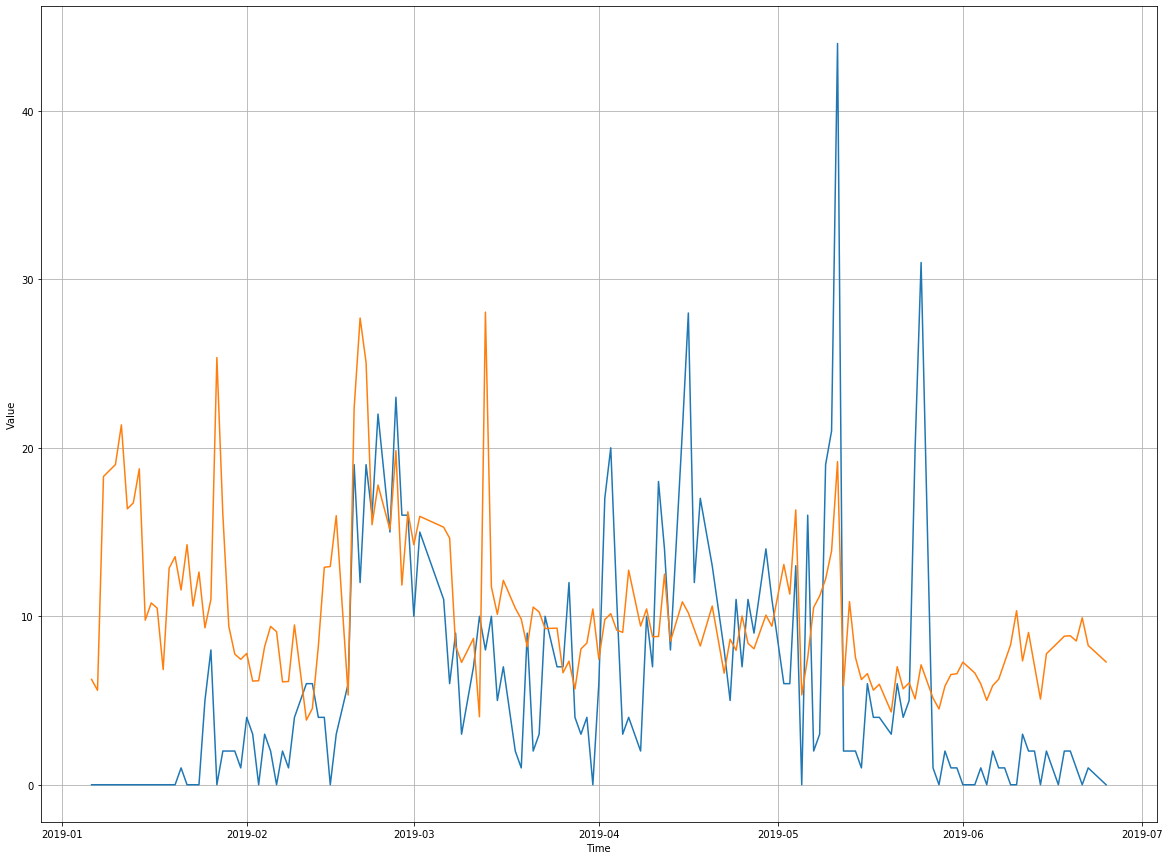

In [29]:
plt.figure(figsize=(20,15))
plot_series(data_2019.index, data_2019)
plot_series(data_2019.index, final_result)

In [30]:
tf.keras.metrics.mean_squared_error(data_2019, final_result).numpy()

73.45368574712346

In [31]:
tf.keras.metrics.mean_absolute_error(data_2019, final_result).numpy()

6.759534403638545

In [32]:
from baseline_tools import naive_forecast, moving_average

In [33]:
naive, real = naive_forecast(data_2019)

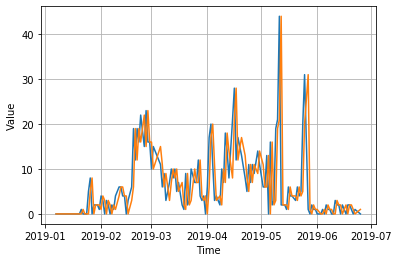

In [34]:
plot_series(real.index, real)
plot_series(real.index, naive)

In [35]:
tf.keras.metrics.mean_squared_error(real, naive).numpy()

46.87248322147651

In [36]:
tf.keras.metrics.mean_absolute_error(real, naive).numpy()

4.0

* Vou nem fazer o ma porque já perdeu do baseline

## Monthly

In [37]:
df

,ENTREGA,GE2 CELULAR,GE1 ELETROPORTATEIS,GE1 CELULAR,CHIP VIVO 4G 128K P19 HRS PRE,GE1 TV LCD LED,CHIP CLARO ODA 128KB TRIPE,GE1 MOVEIS 1,GE2 REFRIGERADOR,CHIP TIM INFINITY PRE HRD TRIPLO 4G,...,CHIP OI 4G HLR 39,GE2 LAV. ROUPAS AUTOMATICA,SUPORTE TV UNIVERSAL LCD/LED 10 A 71 SBRUB750,VENTILADOR 40CM V-49 6P RED PREMIUM,TABLET NB184 M7S QUAD CORE PRETO,GE1 FOGAO 2 A 6 BOCAS,FOGAO 4BC. BALI 4076 BR,VENTILADOR 30CM NV-15 6P BR 220V,CELULAR RIU-I R200 DB PRETO-VERMELHO,CELULAR RIU-I R200 DB PRETO-AMARELO
2015-01-02,22.0,11.0,11.0,22.0,17.0,4.0,0.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,31.0,12.0,24.0,26.0,20.0,4.0,0.0,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-05,41.0,8.0,26.0,28.0,19.0,4.0,0.0,8.0,20.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-01-06,44.0,10.0,22.0,23.0,20.0,4.0,0.0,4.0,7.0,0.0,...,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2015-01-07,55.0,9.0,21.0,38.0,22.0,5.0,0.0,7.0,8.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-19,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,11.0,...,24.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,4.0,0.0
2019-06-20,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,6.0,...,23.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
2019-06-21,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,11.0,...,22.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
2019-06-22,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,...,18.0,0.0,2.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0


In [38]:
df_monthly = df.groupby(pd.Grouper(freq="M")).sum()

In [39]:
df_monthly

,ENTREGA,GE2 CELULAR,GE1 ELETROPORTATEIS,GE1 CELULAR,CHIP VIVO 4G 128K P19 HRS PRE,GE1 TV LCD LED,CHIP CLARO ODA 128KB TRIPE,GE1 MOVEIS 1,GE2 REFRIGERADOR,CHIP TIM INFINITY PRE HRD TRIPLO 4G,...,CHIP OI 4G HLR 39,GE2 LAV. ROUPAS AUTOMATICA,SUPORTE TV UNIVERSAL LCD/LED 10 A 71 SBRUB750,VENTILADOR 40CM V-49 6P RED PREMIUM,TABLET NB184 M7S QUAD CORE PRETO,GE1 FOGAO 2 A 6 BOCAS,FOGAO 4BC. BALI 4076 BR,VENTILADOR 30CM NV-15 6P BR 220V,CELULAR RIU-I R200 DB PRETO-VERMELHO,CELULAR RIU-I R200 DB PRETO-AMARELO
2015-01-31,1174.0,204.0,507.0,637.0,182.0,107.0,0.0,176.0,109.0,0.0,...,0.0,30.0,0.0,1.0,0.0,30.0,0.0,0.0,0.0,0.0
2015-02-28,885.0,188.0,431.0,359.0,1636.0,52.0,0.0,149.0,102.0,0.0,...,0.0,22.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0
2015-03-31,1257.0,197.0,507.0,414.0,137.0,86.0,0.0,159.0,115.0,0.0,...,0.0,33.0,0.0,31.0,0.0,20.0,0.0,0.0,0.0,0.0
2015-04-30,1090.0,230.0,593.0,525.0,178.0,70.0,0.0,160.0,95.0,0.0,...,0.0,25.0,0.0,66.0,17.0,26.0,0.0,0.0,0.0,0.0
2015-05-31,1013.0,255.0,615.0,523.0,356.0,54.0,0.0,176.0,90.0,0.0,...,0.0,17.0,0.0,105.0,45.0,28.0,0.0,0.0,0.0,0.0
2015-06-30,728.0,260.0,337.0,504.0,200.0,71.0,0.0,159.0,46.0,0.0,...,0.0,23.0,0.0,19.0,23.0,21.0,0.0,0.0,0.0,0.0
2015-07-31,1203.0,262.0,428.0,539.0,253.0,59.0,0.0,155.0,50.0,0.0,...,0.0,20.0,0.0,28.0,108.0,36.0,0.0,0.0,0.0,0.0
2015-08-31,1056.0,207.0,313.0,401.0,153.0,63.0,0.0,140.0,87.0,0.0,...,0.0,36.0,0.0,38.0,101.0,28.0,0.0,0.0,0.0,0.0
2015-09-30,1076.0,168.0,330.0,284.0,166.0,34.0,0.0,117.0,73.0,0.0,...,0.0,45.0,0.0,28.0,36.0,17.0,0.0,0.0,0.0,0.0
2015-10-31,924.0,208.0,385.0,278.0,146.0,26.0,276.0,138.0,85.0,0.0,...,0.0,16.0,0.0,16.0,40.0,22.0,0.0,0.0,0.0,0.0


In [40]:
df_monthly["FERRO SECO METALICO VFA 1110X BLACK E DECKER"]

2015-01-31     28.0
2015-02-28     19.0
2015-03-31     36.0
2015-04-30     16.0
2015-05-31      1.0
2015-06-30     52.0
2015-07-31     36.0
2015-08-31     25.0
2015-09-30     44.0
2015-10-31     23.0
2015-11-30     56.0
2015-12-31     25.0
2016-01-31     30.0
2016-02-29     52.0
2016-03-31     48.0
2016-04-30     19.0
2016-05-31     58.0
2016-06-30     42.0
2016-07-31     32.0
2016-08-31     30.0
2016-09-30     59.0
2016-10-31     65.0
2016-11-30     52.0
2016-12-31     48.0
2017-01-31     69.0
2017-02-28     26.0
2017-03-31     37.0
2017-04-30     60.0
2017-05-31    120.0
2017-06-30     45.0
2017-07-31     41.0
2017-08-31     30.0
2017-09-30     26.0
2017-10-31     45.0
2017-11-30     99.0
2017-12-31    114.0
2018-01-31      2.0
2018-02-28      0.0
2018-03-31      0.0
2018-04-30     50.0
2018-05-31     89.0
2018-06-30     62.0
2018-07-31     81.0
2018-08-31     74.0
2018-09-30     62.0
2018-10-31     52.0
2018-11-30     36.0
2018-12-31     11.0
2019-01-31     41.0
2019-02-28     55.0


In [41]:
df_monthly["VENTILADOR VF40 SILENCE FORCE CD RE"]

2015-01-31      0.0
2015-02-28      0.0
2015-03-31      0.0
2015-04-30      0.0
2015-05-31      0.0
2015-06-30      0.0
2015-07-31      0.0
2015-08-31      0.0
2015-09-30      0.0
2015-10-31      0.0
2015-11-30      6.0
2015-12-31     17.0
2016-01-31     55.0
2016-02-29     82.0
2016-03-31    112.0
2016-04-30      0.0
2016-05-31     15.0
2016-06-30     51.0
2016-07-31     29.0
2016-08-31     16.0
2016-09-30     66.0
2016-10-31     39.0
2016-11-30    307.0
2016-12-31    523.0
2017-01-31    219.0
2017-02-28    186.0
2017-03-31     45.0
2017-04-30    173.0
2017-05-31    195.0
2017-06-30     67.0
2017-07-31     94.0
2017-08-31     42.0
2017-09-30     52.0
2017-10-31    140.0
2017-11-30    941.0
2017-12-31    216.0
2018-01-31    415.0
2018-02-28    155.0
2018-03-31    214.0
2018-04-30    163.0
2018-05-31    272.0
2018-06-30     71.0
2018-07-31     77.0
2018-08-31     55.0
2018-09-30     47.0
2018-10-31     93.0
2018-11-30    553.0
2018-12-31    106.0
2019-01-31     21.0
2019-02-28    206.0


In [42]:
ventilador = df_monthly["VENTILADOR VF40 SILENCE FORCE CD RE"]

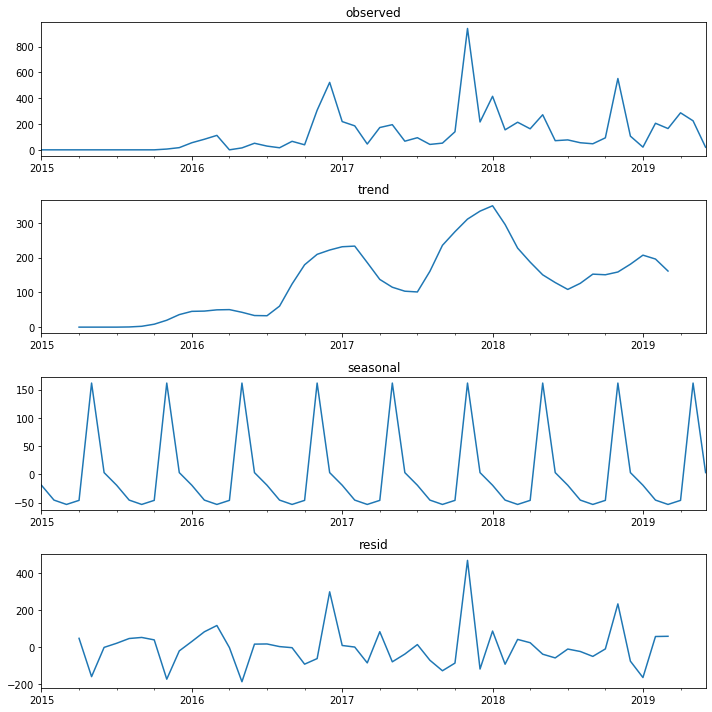

In [43]:
%matplotlib inline
result = seasonal_decompose(ventilador, model = 'additive', period=6)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(10,10))
result.observed.plot(ax = ax1, title = "observed")
result.trend.plot(ax = ax2, title = "trend")
result.seasonal.plot(ax = ax3, title = "seasonal")
result.resid.plot(ax = ax4, title = "resid")
plt.tight_layout()

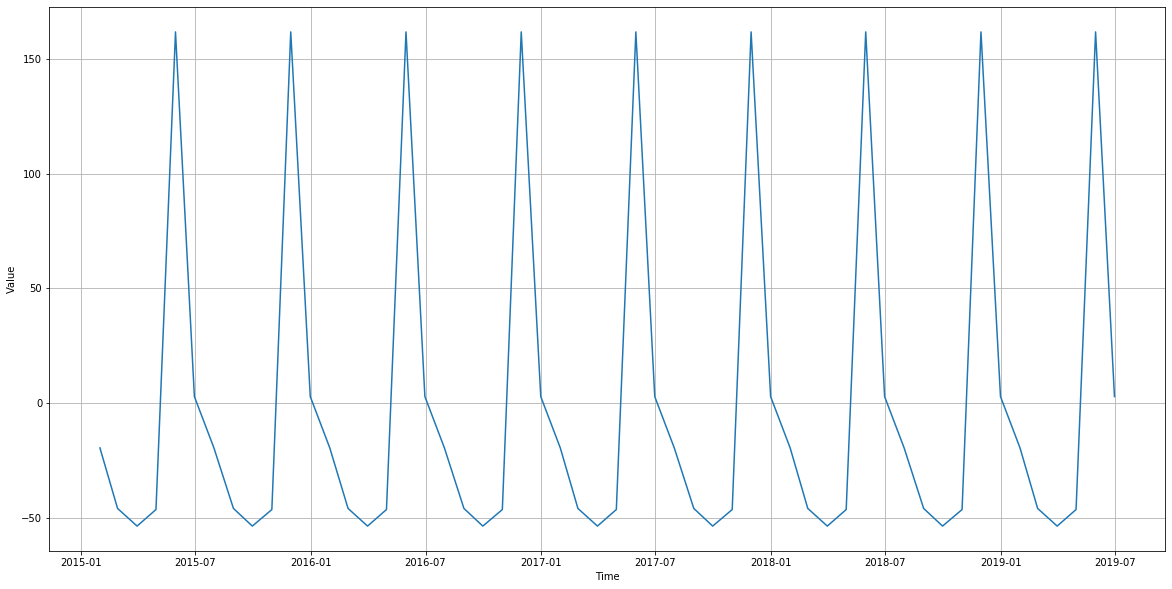

In [44]:
plt.figure(figsize=(20,10))
plot_series(result.seasonal.index, result.seasonal)

In [45]:
result.seasonal.index[-1]

Timestamp('2019-06-30 00:00:00', freq='M')

In [46]:
to_add = result.seasonal.loc[(result.seasonal.index.year == 2018)]
to_add

2018-01-31    -19.354167
2018-02-28    -45.687500
2018-03-31    -53.364583
2018-04-30    -46.166667
2018-05-31    161.593750
2018-06-30      2.979167
2018-07-31    -19.354167
2018-08-31    -45.687500
2018-09-30    -53.364583
2018-10-31    -46.166667
2018-11-30    161.593750
2018-12-31      2.979167
Freq: M, Name: seasonal, dtype: float64

In [47]:
y_train = ventilador.loc[ventilador.index.year != 2019].fillna(0)

In [48]:
X1 = np.array(ventilador.index.year - 2015).reshape(-1,1)

X2 = np.array(ventilador.index.month).reshape(-1,1)

#X3 = np.array(ventilador.index.day).reshape(-1,1)

X = np.concatenate((X1,X2), axis=1)

In [49]:
X

array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 3,  1],
       [ 3,  2],
       [ 3,  3],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 3,  7],
       [ 3,  8],
       [ 3,  9],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 4,  1],
       [ 4,  2],
       [ 4,  3],
       [ 4,  4],
       [ 4,  5],
       [ 4,  6]])

In [50]:
class LinearRegressor:
    def execute(self, X, y):
        X = np.array(X)
        y = np.array(y)
        XTX = np.dot(X.transpose(), X)
        inverse = np.linalg.inv(XTX)
        self.W = np.dot(np.dot(inverse, X.transpose()), y)
    
    def predict(self, X):
        return [np.dot(self.W, d) for d in X]

In [51]:
X_train = X[(X[:,0] != 4)]
X_test = X[X[:,0] == 4]

In [52]:
lr = LinearRegressor()

In [53]:
lr.execute(X_train, y_train)

In [54]:
y_pred = lr.predict(X_test)

In [55]:
len(y_pred)

6

In [56]:
X_test.shape

(6, 2)

In [57]:
to_add = to_add.loc[to_add.index.month < 7] # pega só os dados de sazonalidade de 2018, do mesmo período que vamos prever em 2019

In [58]:
to_add

2018-01-31    -19.354167
2018-02-28    -45.687500
2018-03-31    -53.364583
2018-04-30    -46.166667
2018-05-31    161.593750
2018-06-30      2.979167
Freq: M, Name: seasonal, dtype: float64

In [59]:
to_add.shape

(6,)

In [60]:
final_result = np.array(to_add) + y_pred

In [61]:
data_2019 = ventilador.loc[ventilador.index.year == 2019]
data_2019 = data_2019.loc[data_2019.index.month < 7]
data_2019 = data_2019

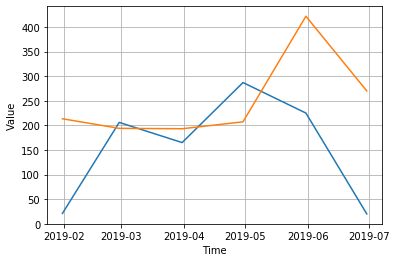

In [62]:
plot_series(data_2019.index, data_2019)
plot_series(data_2019.index, final_result)

In [63]:
tf.keras.metrics.mean_squared_error(data_2019, final_result).numpy()

24260.856141203258

In [64]:
tf.keras.metrics.mean_absolute_error(data_2019, final_result).numpy()

126.53834674160605

In [65]:
naive, real = naive_forecast(data_2019)

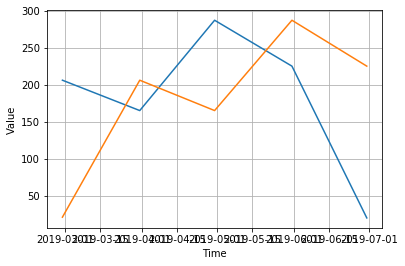

In [66]:
plot_series(real.index, real)
plot_series(real.index, naive)

In [67]:
tf.keras.metrics.mean_squared_error(real, naive).numpy()

19331.8

In [68]:
tf.keras.metrics.mean_absolute_error(real, naive).numpy()

123.0

* Mensal nem deu muito certo, como não é o nosso objetivo